# AMPLab assignment: text-based audio classification 
Original notebook wirtten by Frederic Font, extended by Philip Tovstogan

# PART B - Classification

To run the cells in this notebook you'll need to install the following Python dependencies:
 * `numpy`
 * `sklearn`
 * `matplotlib`

If you have not installed them you should be able to do so by running: `pip install numpy sklearn matplotlib`.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import utils
import random
import collections
import numpy
from sklearn import svm, tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from IPython.core.display import display, HTML

try:  # This is for compatiblitily python2/python3 of xrange function
    xrange
except NameError:
    xrange = range

### Load previously created dataset

Set `DATASET_NAME` to the dataset you want to load.

In [2]:
# Load dataset from saved file
DATASET_NAME = 'bowed_vs_plucked'
dataset = utils.load_from_json('%s.json' % DATASET_NAME)
print('Loaded dataset with %i classes:' % len(dataset))
for klass, sounds in dataset.items():
    print('\t%s: %i sounds' % (klass, len(sounds)))
class_names = list(dataset.keys())  # This is just for convenience, reused later on

Loaded dataset with 2 classes:
	Plucked string instrument: 200 sounds
	Bowed string instrument: 200 sounds


### 3) Define vector space

Here we create a prototype feature vector that will define the way in which our documetns are represented for classification purposes. You can set the number of dimensions of the vector sepace/feature vector by editing the parameter `NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR` below.

In [3]:
def build_tag_vector_space(n_dimensions, dataset, class_names): 
    # Get all tags in the dataset (the vocabulary)
    all_tags = list()
    for class_name in class_names:
        class_tags = utils.get_all_tags_from_class(class_name, dataset)
        all_tags += class_tags
        
    # Filter out tags with less frequency (get only top N tags)
    most_common_tags_counts = collections.Counter(all_tags).most_common(n_dimensions)
    most_common_tags = [tag for tag, _ in most_common_tags_counts]
    filtered_tags = [tag for tag in most_common_tags if tag in all_tags]
    
    # Build our prototype feature vector (unique list of tags), and print first 10 tags
    prototype_feature_vector = list(set(filtered_tags))
    print('Created prototype feature vector with %i dimensions (originally the space had %i dimensions)' % (
        len(prototype_feature_vector), len(set(all_tags))))
    print('Prototype vector tags (sorted by occurrence in filtered_tags):')
    for count, (tag, frequency) in enumerate(most_common_tags_counts):
        print('\t%i %s (%i ocurrences)' % (count + 1, tag, frequency))
    return prototype_feature_vector


NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 5 # Maximum number of dimensions for the feature vector.

prototype_feature_vector = build_tag_vector_space(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
    dataset=dataset,
    class_names=class_names,
)

Created prototype feature vector with 5 dimensions (originally the space had 450 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 multisample (159 ocurrences)
	2 guitar (150 ocurrences)
	3 single-note (104 ocurrences)
	4 acoustic (97 ocurrences)
	5 pizzicato (88 ocurrences)


### 4) Project documents in the vector space

The cell below shows you how to project a document to the vector space, that is to say, how to get the feature vector of a specific sound form our dataset. You can run this cell multiple times to see the feature vector of different randomly chosen sounds.

In [4]:
# Example of getting feature vector from tags list...
random_sound = random.choice(dataset[random.choice(class_names)])
random_sound_tags = random_sound['tags']
random_sound_feature_vector = utils.get_feature_vector_from_tags(random_sound_tags, prototype_feature_vector)

display(HTML(utils.get_sound_embed_html(random_sound['id'])))
print('Chosen sound has tags:', ', '.join(random_sound_tags))
html = '<table><tr><td>'
html += '</td><td>'.join([tag for tag in prototype_feature_vector])
html += '</td></tr><tr><td>'
html += '</td><td>'.join(['x' if prototype_feature_vector[count] in random_sound_tags else '' 
                          for count, item in enumerate(random_sound_feature_vector)])
html += '</td></tr></table>'
display(HTML(html))

Chosen sound has tags: guitar, velocity, 1-shot, multisample, acoustic


acoustic,single-note,guitar,pizzicato,multisample
x,,x,,x


### 5) Define train and testing set

In this cell we create the training and test sets that will be used to train our classifier and evaluate its accuracy.

Set the `PERCENTAGE_OF_TRAINING_DATA` to decide which percentage of data goes to training and which goes to testing.
Set `MAX_INPUT_TAGS_FOR_TESTING` to decide the maximum number of tags that will be used for each sound in the test send to predict its category. Set it to a big number (~20) to effectievly bypass this parameter.

In [5]:
def create_train_and_test_sets(dataset, class_names, percentage_training_data, 
                               max_input_tags_for_testing):
    training_set = dict()
    testing_set = dict()

    # Get 'n_training_sounds_per_class' sounds per class 
    for class_name, sounds in dataset.items():
        n_training_sounds_per_class = int(len(sounds) * percentage_training_data)
        sounds_from_class = sounds[:] # Copy the list so when we later shuffle it does not affect the original data 
        random.shuffle(sounds_from_class)
        training_set[class_name] = sounds_from_class[:n_training_sounds_per_class] # First sounds for training
        testing_set[class_name] = sounds_from_class[n_training_sounds_per_class:] # Following sounds for testing
     
        # Save a trimmed version of input tags for testing sounds
        for sound in testing_set[class_name]:
            sound['tags'] = random.sample(sound['tags'], min(max_input_tags_for_testing, len(sound['tags'])))

    print('Created training and testing sets with the following number of sounds:\n\tTrain\tTest')
    for class_name in class_names:
        training_sounds = training_set[class_name]
        testing_sounds = testing_set[class_name]
        print('\t%i\t%i\t%s' % (len(training_sounds), len(testing_sounds), class_name))
    return training_set, testing_set


PERCENTAGE_OF_TRAINING_DATA = 0.75 # Percentage of sounds that will be used for training (others are for testing)
MAX_INPUT_TAGS_FOR_TESTING = 20 # Use a big number to "omit" this parameter and use as many tags as originally are in the sound

training_set, testing_set = create_train_and_test_sets(
    dataset=dataset, 
    class_names=class_names,
    percentage_training_data=PERCENTAGE_OF_TRAINING_DATA,
    max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING,
)

Created training and testing sets with the following number of sounds:
	Train	Test
	150	50	Plucked string instrument
	150	50	Bowed string instrument


### 6) Train classifier

Train the classifier with the training set that we prepared. User `CLASSIFIER_TYPE` parameter below to chose which type of classifier you want to use. This code currently supports Super Vector Mahcines (`svm`), and Decision Trees (`tree`). You might want to try adding further classifier types here.

Note that when using the `tree` classifier, the output of the tree is saved into an image and shown here. This is interesting to learn about what did the classifier learn. To show these trees, you'll need to install **Graphviz** and run the `dot` command line tool. 

In [6]:
def build_tag_feature_vector(sound):
    tag_features = utils.get_feature_vector_from_tags(sound['tags'], prototype_feature_vector)
    return np.concatenate([[], tag_features])

def train_classifier(training_set, classifier_type, class_names, dataset_name, feature_vector_func, 
                     feature_vector_dimension_labels=None, tree_max_depth=5):
    
    # Prepare data for fitting classifier (as sklearn classifiers require)
    classes_vector = list()
    feature_vectors = list()
    for class_name, sounds in training_set.items():
        for count, sound in enumerate(sounds):
            # Use index of class name in class_names as numerical value (classifier internally represents 
            # class label as number)
            classes_vector.append(class_names.index(class_name))
            feature_vector = feature_vector_func(sound)
            feature_vectors.append(feature_vector)

    # Create and fit classifier
    print('Training classifier (%s) with %i sounds...' % (CLASSIFIER_TYPE, len(feature_vectors)))
    if classifier_type == 'svm':
        classifier = svm.LinearSVC()
        classifier.fit(feature_vectors, classes_vector)
    elif classifier_type == 'tree':
        classifier = tree.DecisionTreeClassifier(max_depth=tree_max_depth)
        classifier.fit(feature_vectors, classes_vector)
        
        # Plot classifier decision rules
        utils.print_tree_as_text(classifier, feature_vector_dimension_labels, class_names)
    
        # Alternatively you can do nicer plot with images, but this requires Graphviz to be installed
        # WARNING: do not run this if tree is too big, might freeze
        #out_filename = '%s_tree_%i.png' % (dataset_name, random.randint(1000,9999))
        #utils.export_tree_as_graph(
        #    classifier, feature_vector_dimension_labels, class_names=class_names, filename=out_filename)
        #display(HTML('<h4>Learned tree:</h4><img src="%s"/>' % out_filename))
    else:
        raise Exception('Bad classifier type!!!')
    
    print('done!')
    return classifier

CLASSIFIER_TYPE = 'tree' # Use 'svm' or 'tree'

classifier = train_classifier(
    training_set=training_set,
    classifier_type=CLASSIFIER_TYPE, 
    class_names=class_names, 
    dataset_name=DATASET_NAME,
    feature_vector_func=build_tag_feature_vector,
    feature_vector_dimension_labels=prototype_feature_vector,  # This is used to show the class names in the tree image
)

Training classifier (tree) with 300 sounds...
if guitar =< 0.5: 
  |then if multisample =< 0.5: 
  |  |then if pizzicato =< 0.5: 
  |  |  |then if acoustic =< 0.5: 
  |  |  |  |then Plucked string instrument
  |  |  |  |else Bowed string instrument
  |  |  |else Bowed string instrument
  |  |else if single-note =< 0.5: 
  |  |  |then if pizzicato =< 0.5: 
  |  |  |  |then Bowed string instrument
  |  |  |  |else Bowed string instrument
  |  |  |else Bowed string instrument
  |else Plucked string instrument
<---------->
Tree Depth:  4
done!


### 7) Evaluate classification

The function below evaluated the classifier build in the previous cell and shows some results. 

Evaluating with 100 instances...
done!
96 correct predictions
4 wrong predictions
Overall accuracy 96.00%
Confusion matrix


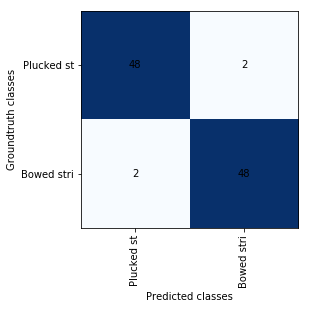

0.96

In [7]:
def evaluate_classifier(testing_set, classifier, class_names, feature_vector_func, show_confusion_matrix=True):
    # Test with testing set
    print('Evaluating with %i instances...' % sum([len(sounds) for sounds in testing_set.values()]))
    predicted_data = list()
    for class_name, sounds in testing_set.items():
        for count, sound in enumerate(sounds):
            feature_vector = feature_vector_func(sound)
            predicted_class_name = class_names[classifier.predict([feature_vector])[0]]
            predicted_data.append((sound['id'], class_name, predicted_class_name))     
    print('done!')

    # Compute overall accuracy
    good_predictions = len([1 for sid, cname, pname in predicted_data if cname == pname])
    wrong_predictions = len([1 for sid, cname, pname in predicted_data if cname != pname])
    print('%i correct predictions' % good_predictions)
    print('%i wrong predictions' % wrong_predictions)
    accuracy = float(good_predictions)/(good_predictions + wrong_predictions)
    print('Overall accuracy %.2f%%' % (100 * accuracy))
    
    if show_confusion_matrix:
        # Compute confussion matrix (further analysis)
        matrix = list()
        for class_name in class_names:
            predicted_classes = list()
            for sid, cname, pname in predicted_data:
                if cname == class_name:
                    predicted_classes.append(pname)
            matrix.append([predicted_classes.count(target_class) for target_class in class_names])

        # Plot confussion matrix
        fig = plt.figure()
        plt.clf()
        ax = fig.add_subplot(111)
        ax.set_aspect(1)
        res = ax.imshow(matrix, cmap=plt.cm.Blues, interpolation='nearest')

        for x in xrange(len(matrix)):
            for y in xrange(len(matrix)):
                ax.annotate(str(matrix[x][y]), xy=(y, x), 
                            horizontalalignment='center',
                            verticalalignment='center')

        shortened_class_names = [item[0:10] for item in class_names]
        plt.xticks(range(len(class_names)), shortened_class_names, rotation=90)
        plt.yticks(range(len(class_names)), shortened_class_names)
        plt.xlabel('Predicted classes')
        plt.ylabel('Groundtruth classes')

        print('Confusion matrix')
        plt.show()
    
    return accuracy
    
evaluate_classifier(
    testing_set=testing_set,
    classifier=classifier,
    class_names=class_names,
    feature_vector_func=build_tag_feature_vector,
)

<h2 style="color:#AB4646;">Using audio features</h2>

Created prototype feature vector with 5 dimensions (originally the space had 450 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags):
	1 multisample (159 ocurrences)
	2 guitar (149 ocurrences)
	3 single-note (104 ocurrences)
	4 acoustic (97 ocurrences)
	5 pizzicato (88 ocurrences)
Created training and testing sets with the following number of sounds:
	Train	Test
	150	50	Plucked string instrument
	150	50	Bowed string instrument
Training classifier (tree) with 300 sounds...
if guitar =< 0.5: 
  |then if multisample =< 0.5: 
  |  |then if pizzicato =< 0.5: 
  |  |  |then if acoustic =< 0.5: 
  |  |  |  |then if hfc =< 1.625746250152588: 
  |  |  |  |  |then Plucked string instrument
  |  |  |  |  |else Plucked string instrument
  |  |  |  |else if spectral_centroid =< 1055.430908203125: 
  |  |  |  |  |then Bowed string instrument
  |  |  |  |  |else Plucked string instrument
  |  |  |else Bowed string instrument
  |  |else if single-note =< 0.5: 
  |  |  |then if hf

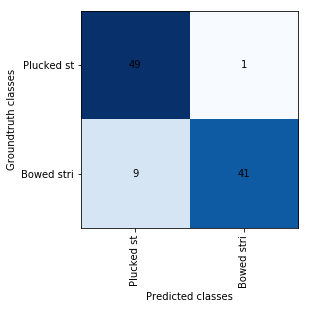

0.9

In [8]:
# Expriment using duration

CLASSIFIER_TYPE = 'tree'
PERCENTAGE_OF_TRAINING_DATA = 0.75
NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 5
MAX_INPUT_TAGS_FOR_TESTING = 20

def build_audio_feature_vector(sound):
    tag_features = utils.get_feature_vector_from_tags(sound['tags'], prototype_feature_vector)
    audio_features = [
        sound['analysis']['lowlevel']['spectral_centroid']['mean'],
        sound['analysis']['lowlevel']['hfc']['mean']
    ]
    # Some sounds seem to have no duration value (no analysis), in this case we sould probably remove them from the dataset
    return np.concatenate([[], tag_features, numpy.array(audio_features)])

# CODE TO CLEAN DATASET (remove sounds which do not have analysis information)
dataset_cleaned = {}
for key, sounds in dataset.items():
    if key not in dataset_cleaned:
        dataset_cleaned[key] = []
    for sound in sounds:
        if sound['analysis'] is not None:
            dataset_cleaned[key].append(sound)

prototype_feature_vector = []
prototype_feature_vector = build_tag_vector_space(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
    dataset=dataset,
    class_names=class_names,
)

training_set, testing_set = create_train_and_test_sets(
    dataset=dataset_cleaned, class_names=class_names,
    percentage_training_data=PERCENTAGE_OF_TRAINING_DATA, max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING)

feature_names = prototype_feature_vector[:]
feature_names.append('spectral_centroid')
feature_names.append('hfc')

classifier = train_classifier(
    training_set=training_set, classifier_type=CLASSIFIER_TYPE, class_names=class_names, dataset_name=DATASET_NAME,
    feature_vector_func=build_audio_feature_vector, feature_vector_dimension_labels=feature_names,
)

evaluate_classifier(
    testing_set=testing_set, classifier=classifier, class_names=class_names, 
    feature_vector_func=build_audio_feature_vector)

## Comparing performance with/without audio features
*We do side-by side comparison of pure tag classifier and hybrid classifier (with audio features mixed in). Because accuracy*

In [9]:
%%capture
CLASSIFIER_TYPE = 'tree'
PERCENTAGE_OF_TRAINING_DATA = 0.75
NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 5
MAX_INPUT_TAGS_FOR_TESTING = 20
ITERATIONS = 100

results = np.zeros((2, ITERATIONS))

prototype_feature_vector = build_tag_vector_space(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
    dataset=dataset,
    class_names=class_names,
)

feature_names = prototype_feature_vector[:]
feature_names.append('spectral_centroid')
feature_names.append('hfc')

for i in xrange(ITERATIONS):    
    training_set, testing_set = create_train_and_test_sets(
        dataset=dataset_cleaned, class_names=class_names,
        percentage_training_data=PERCENTAGE_OF_TRAINING_DATA, max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING)

    tag_classifier = train_classifier(
        training_set=training_set, classifier_type=CLASSIFIER_TYPE, class_names=class_names, dataset_name=DATASET_NAME,
        feature_vector_func=build_tag_feature_vector, feature_vector_dimension_labels=prototype_feature_vector, 
    )

    audio_classifier = train_classifier(
        training_set=training_set, classifier_type=CLASSIFIER_TYPE, class_names=class_names, dataset_name=DATASET_NAME,
        feature_vector_func=build_audio_feature_vector, feature_vector_dimension_labels=feature_names,
    )

    results[0,i] = evaluate_classifier(
        testing_set=testing_set, classifier=tag_classifier, class_names=class_names, 
        feature_vector_func=build_tag_feature_vector, show_confusion_matrix=False)

    results[1,i] = evaluate_classifier(
        testing_set=testing_set, classifier=audio_classifier, class_names=class_names, 
        feature_vector_func=build_audio_feature_vector, show_confusion_matrix=False)


In [10]:
print('Mean: ', np.mean(results, axis=1))
print('Std: ', np.std(results, axis=1))

Mean:  [ 0.9324  0.9195]
Std:  [ 0.02478387  0.02628212]


*Inclusion of audio features degraded accuracy from 0.93 to 0.91 with standard deviation equal to 0.02. That indicates that while the classes are mostly consistent with the tags, the audio content is less useful input to classify sounds. That is actually not a good indicator of the quality of our data, because inclusion of the actual audio content makes classification a bit less accurate. *